---
author: 
  - name: Matthew Reda
    email: redam94@gmail.com
copyright: 
  holder: Matthew Reda
  year: 2024
citation: true
---

# Optimizer

> Optimizers for models

In [ ]:
#| default_exp optimizer

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide
from nbdev.showdoc import *
import matplotlib.pyplot as plt

In [ ]:
#| export
import numpy as np
import pandas as pd
import scipy.optimize as opt

from budget_optimizer.utils.model_classes import BaseBudgetModel
from budget_optimizer.utils.model_helpers import (
  load_module,
  load_yaml,
  BudgetType, 
  AbstractModel
)

from pathlib import Path

In [ ]:
#| export
class Optimizer:
    """Optimizer wrapper for the pyswarms package"""
    _CONFIG_YAML = 'optimizer_config.yaml'
    _MODULE_FILE = "optimizer_config.py"
    
    def __init__(
        self, 
        model: BaseBudgetModel, # The model to optimize
        config_path: str|Path # Path to the configuration files
        ):
        
        self.model: BaseBudgetModel = model
        self._config_path: Path = Path(config_path) if isinstance(config_path, str) else config_path
        self.optimal_budget: BudgetType = None
        self.optimal_prediction: xr.DataArray = None
        self.optimal_contribution: xr.Dataset = None
        self.sol = None
        self._config = self._load_config()
        self._loss_fn = self._load_loss_fn()
        
    def _load_config(self):
        config = load_yaml(self._config_path / self._CONFIG_YAML)
        return config
    
    def reload_config(self):
        self._config = self._load_config()
        return self
    
    def _load_loss_fn(self):
        """Load the loss function from the config file"""
        module = load_module(self._MODULE_FILE.replace(".py", ""), self._config_path / self._MODULE_FILE)
        return module.loss_fn
    
    def _optimizer_array_to_budget(self, array: np.ndarray) -> BudgetType:
        """Convert the optimizer array to a budget"""
        initial_budget: BudgetType = self._config['initial_budget']
        budget: BudgetType = {}
        
        for i, key in enumerate(initial_budget.keys()):
            budget[key] = array[i]
        return budget
    
    def _optimizer_fn(self, x: np.ndarray):
        """Optimizer step"""
        budget = self._optimizer_array_to_budget(x)
        prediction = self.model.predict(budget)
        loss = self._loss_fn(prediction, **self._config['loss_fn_kwargs'])
        return loss
    
    def optimize(
        self, 
        init_pos: np.ndarray, # Initial position of the optimizer
        bounds: list[tuple[float, float]], # Bounds for the optimizer
        constraints: None|opt.LinearConstraint = None # Constraints for the optimizer
        ):
        """Optimize the model"""
        import warnings
        warnings.filterwarnings("ignore")
        self.sol = opt.minimize(
            self._optimizer_fn, init_pos,
            method='trust-constr', 
            bounds=bounds, 
            constraints=constraints
            )
        if not self.sol.success:
            raise Exception(f"Optimization failed: {self.sol.message}")
        
        self.optimal_budget = self._optimizer_array_to_budget(self.sol.x)
        self.optimal_prediction = self.model.predict(self.optimal_budget) # The optimizer minimizes the cost, so we need to negate it
        self.optimal_contribution = self.model.contributions(self.optimal_budget)
        return self

In [ ]:
class BudgetModel(BaseBudgetModel):
    """
    Budget model class
    """
    ...

In [ ]:
m = BudgetModel("Revenue Model", "Revenue", "../example_files/model_1")

In [ ]:
init_budget = np.array([2, 3])
bounds = [(1.8, 2.2), (2.7, 3.3)]
constraints = opt.LinearConstraint([[1, 1]], [5], [5])
o = Optimizer(m, "../example_files")

In [ ]:
show_doc(Optimizer.optimize)

---

[source](https://github.com/redam94/budget_optimizer/blob/main/budget_optimizer/optimizer.py#L73){target="_blank" style="float:right; font-size:smaller"}

### Optimizer.optimize

>      Optimizer.optimize (init_pos:numpy.ndarray,
>                          bounds:list[tuple[float,float]], constraints:None|sci
>                          py.optimize._constraints.LinearConstraint=None)

*Optimize the model*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| init_pos | ndarray |  | Initial position of the optimizer |
| bounds | list |  | Bounds for the optimizer |
| constraints | None \| scipy.optimize._constraints.LinearConstraint | None | Constraints for the optimizer |

In [ ]:
o_fitted = o.optimize(init_budget, bounds, constraints)

In [ ]:
#| echo: false
o_fitted.sol

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: -532.9557043474017
                 x: [ 1.800e+00  3.200e+00]
               nit: 11
              nfev: 27
              njev: 9
              nhev: 0
          cg_niter: 7
      cg_stop_cond: 1
              grad: [-2.642e+01 -3.602e+01]
   lagrangian_grad: [ 2.607e-10 -2.607e-10]
            constr: [array([ 5.000e+00]), array([ 1.800e+00,  3.200e+00])]
               jac: [array([[ 1.000e+00,  1.000e+00]]), array([[ 1.000e+00,  0.000e+00],
                           [ 0.000e+00,  1.000e+00]])]
       constr_nfev: [0, 0]
       constr_njev: [0, 0]
       constr_nhev: [0, 0]
                 v: [array([ 3.602e+01]), array([-9.595e+00,  6.393e-03])]
            method: tr_interior_point
        optimality: 2.607218789821286e-10
  constr_violation: 0.0
    execution_time: 0.05707573890686035
         tr_radius: 1133.1696179813518
    constr_penalty: 1.0
 ba

In [ ]:
#| echo: false
print("Optimal budget:")
print({key: np.round(value, 2) for key, value in o_fitted.optimal_budget.items()})

Optimal budget:
{'a': np.float64(1.8), 'b': np.float64(3.2)}


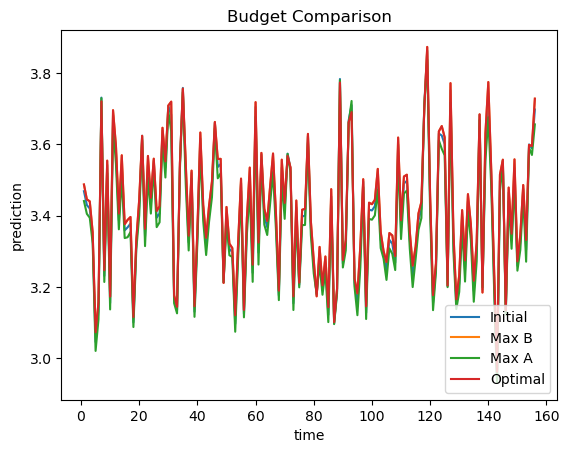

In [ ]:
#| echo: false
m.predict({'a': 2, 'b': 3}).plot(label="Initial")
m.predict({'a': 1.8, 'b': 3.2}).plot(label="Max B")
m.predict({'a': 2.2, 'b': 2.8}).plot(label="Max A")
o_fitted.optimal_prediction.plot(label="Optimal")
plt.title("Budget Comparison")
plt.legend();

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()